## 1. サマリーしたデータを読み込んで可視化する
前のステップで処理したデータはS3バケットに格納されているので、Notebook内に読み込んで可視化するところから始めます  

In [11]:
import awswrangler as wr
import pandas as pd
import boto3

In [12]:
bucket = 'tuki-bkt-misc'
prefix = 'data/nyctaxi/daily_w_location'

In [13]:
s3 = boto3.client('s3')
response = s3.list_objects(Bucket=bucket, Prefix=prefix)
nyctaxi_summary_files = sorted([x['Key'] for x in response['Contents']])
nyctaxi_summary_files = [x for x in nyctaxi_summary_files if ('green' in x) and ('2019' in x or '2020' in x)]
nyctaxi_summary_files

['data/nyctaxi/daily_w_location/nyctaxi_tripdata_green_20190101.csv',
 'data/nyctaxi/daily_w_location/nyctaxi_tripdata_green_20190102.csv',
 'data/nyctaxi/daily_w_location/nyctaxi_tripdata_green_20190103.csv',
 'data/nyctaxi/daily_w_location/nyctaxi_tripdata_green_20190104.csv',
 'data/nyctaxi/daily_w_location/nyctaxi_tripdata_green_20190105.csv',
 'data/nyctaxi/daily_w_location/nyctaxi_tripdata_green_20190106.csv',
 'data/nyctaxi/daily_w_location/nyctaxi_tripdata_green_20190107.csv',
 'data/nyctaxi/daily_w_location/nyctaxi_tripdata_green_20190108.csv',
 'data/nyctaxi/daily_w_location/nyctaxi_tripdata_green_20190109.csv',
 'data/nyctaxi/daily_w_location/nyctaxi_tripdata_green_20190110.csv',
 'data/nyctaxi/daily_w_location/nyctaxi_tripdata_green_20190111.csv',
 'data/nyctaxi/daily_w_location/nyctaxi_tripdata_green_20190112.csv',
 'data/nyctaxi/daily_w_location/nyctaxi_tripdata_green_20190113.csv',
 'data/nyctaxi/daily_w_location/nyctaxi_tripdata_green_20190114.csv',
 'data/nyctaxi/daily

blog執筆時点では、2019年1月1日から約1年半分のデータが取得できています。読み込み処理には数分かかります。

In [14]:
df_data = pd.DataFrame()
for file in nyctaxi_summary_files:
    df_read = wr.s3.read_csv(f's3://{bucket}/{file}')
    df_data = pd.concat([df_data, df_read])

In [15]:
print('Number of records:', df_data.shape[0])

Number of records: 1157445


それでは、読み込んだデータをプロットします。

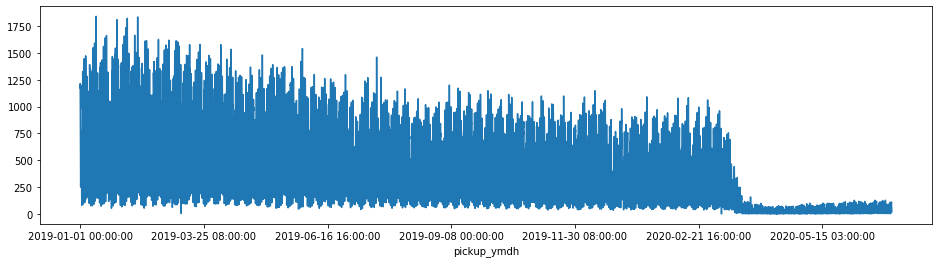

In [16]:
df_data.groupby(by='pickup_ymdh')['count'].sum().plot(figsize=(16,4))

2019年1月から漸減傾向ながらもピーク時に1000を超える程度の数値で推移していた「1時間あたりのgreenタクシーピックアップ数」が、2020年の4月前後から顕著に少なくなっていることが読み取れます。COVID-19の影響でNew Yorkにおいてもロックダウンが実施されたため、それによる外出の減少がタクシーの需要にも大きな影響を及ぼしたことがわかります。COVID-19の影響によるデータドリフトが、タクシー需要に現れているとも言えます。  
ここからは、タクシー需要を予測するモデルを運用していたときに、Model Monitorによってデータ傾向を監視していたとしたらどのような指標の変化が現れるのか、どのようにして変化を検出できるのか、を見ていきましょう。  

## 2. タクシー需要の予測モデルを構築する
まず簡易な予測モデルを作成して、タクシー需要を予測します。ここではXGBoostを使用して、自己回帰に近いモデルを作成しています。  
ここまでのステップで2019年1月からのデータを取得しているので、「2019年1月から12月までのデータを用いてモデルを構築し、2020年1月からモデルの運用を開始した」とします。
つまり、モデルの運用から約3ヶ月間は平常状態で、4ヶ月後にデータドリフトに直面することになります。

In [20]:
df_data.groupby(by=['pickup_ymdh'])['count'].sum().reset_index()

,pickup_ymdh,count
0,2019-01-01 00:00:00,1175
1,2019-01-01 01:00:00,1214
2,2019-01-01 02:00:00,1074
3,2019-01-01 03:00:00,896
4,2019-01-01 04:00:00,728
...,...,...
13120,2020-06-30 19:00:00,81
13121,2020-06-30 20:00:00,41
13122,2020-06-30 21:00:00,24
13123,2020-06-30 22:00:00,25


In [8]:
import datetime
import json
import random
import math
import numpy as np
import pandas as pd

import boto3
import sagemaker

In [5]:
# set random seeds for reproducibility
np.random.seed(42)
random.seed(42)

sagemaker_session = sagemaker.Session()

In [6]:
# DeepARを利用するために必要な環境変数を設定
role = sagemaker.get_execution_role()
region = boto3.Session().region_name

# データ入出力に利用するS3 bucketとパスを設定
model_prefix = 'model/nyctaxi-deepar'
s3_data_path = "s3://{}/{}/data".format(bucket, model_prefix)
s3_output_path = "s3://{}/{}/output".format(bucket, model_prefix)

# SageMakerのDeepARコンテナを指定
region = sagemaker_session.boto_region_name
image_name = sagemaker.amazon.amazon_estimator.get_image_uri(region, "forecasting-deepar", "latest")

'get_image_uri' method will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.


In [127]:
# 利用する時系列データの周期を宣言する
freq = '1H'

# 4時間後までの予測を行う
prediction_length = 4

# we also use 7 days as context length, this is the number of state updates accomplished before making predictions
context_length = 2 * 24

# 学習に利用するデータの範囲を指定する
train_start = pd.Timestamp("2019-01-01 00:00:00", freq=freq)
validation_start = pd.Timestamp("2019-09-01 00:00:00", freq=freq)
test_start = pd.Timestamp("2019-11-01 00:00:00", freq=freq)
test_end = pd.Timestamp("2020-01-01 00:00:00", freq=freq)

モデルの構築に利用できるのは2019年中のデータなので、2019年1月から8月までのデータをトレーニング、9月と10月のデータをバリデーション, 11月と12月のデータをテスト用に使用します。  
Amazon SageMakerが提供するDeepARアルゴリズムはS3からデータを取得して動作するので、分離したデータをS3に保管します。  

In [128]:
# DeepARの必要フォーマットにあわせてDataFrameからDictに整形する処理
# 特徴量抽出も併せて実行している
def convert_to_DeepAR_dict(df, label_col, start_dataset):
    # 予測対象をリスト化してtargetとしてセット
    # JSON形式で学習データを与えるので、欠損値は"NaN"文字列に変換する
    # 詳細はURLを参照：https://docs.aws.amazon.com/ja_jp/sagemaker/latest/dg/deepar.html#deepar-inputoutput
    ts_target = df[label_col].fillna('NaN').tolist()
    
    # 必要に応じて追加特徴量をdynamic_feat Listにセット
    dynamic_feat = []
        
    # 必要に応じてセルごとの特徴を表すカテゴリ変数を設定する
    
    # カテゴリ変数をリストにマージ

    # DeepARの要求フォーマットに合わせてDictに整形
    return {'start': str(start_dataset), 'target': ts_target}

In [129]:
# Pickup locationごとにレコードがあるdf_dataを、日時（YYYYMMDD HH）ごとに1レコードに集約して学習データとして利用する
df_summary = df_data.groupby(by=['pickup_ymdh'])['count'].sum().reset_index()
df_summary['pickup_ymdh'] = pd.to_datetime(df_summary['pickup_ymdh'])
df_summary = df_summary.set_index('pickup_ymdh')

# トレーニングデータ期間の開始からバリデーションデータ期間の直前までをトレーニングデータとして切り出す
df_train = df_summary[train_start:validation_start - datetime.timedelta(hours=1)]
print('Train Data     :', df_train.shape[0], ' ,Last timestamp:', df_train.tail(1).index.values)

Train Data     : 5832  ,Last timestamp: ['2019-08-31T23:00:00.000000000']


In [130]:
# 学習データをDeepARが必要とする辞書形式に変換する
training_data = []
training_data.append(convert_to_DeepAR_dict(df_train, 'count', start_dataset))
    
print('Number of training time series: {}'.format(len(training_data)))
for i in range(0,min(len(training_data), 10)):
    print('length of training time series {}: {}'.format(i, len(training_data[i]['target'])))

Number of training time series: 1
length of training time series 0: 5832


In [131]:
# 61日間のバリデーションデータを予測期間（例：24時間、4時間、1時間）に即して複数のテストデータに分割する
num_test_windows = int(61 * 24 / prediction_length)

# DeepARの必要フォーマットにあわせてバリデーションデータを変形する
validation_data = []
validation_data_info = []

# 処理中のメッシュコードを抽出し、学習データとして与える範囲に絞ってから時系列データとしてリサンプル

# バリデーションデータ期間をprediction_lengthで割った分だけ時系列を生成する
for k in range(1, num_test_windows + 1):
    df_validation = df_summary[train_start:validation_start + datetime.timedelta(hours= k * prediction_length)].copy().asfreq(freq)
    validation_data.append(convert_to_DeepAR_dict(df_validation, 'count', train_start))

    # テストデータの情報は精度評価時に利用するため補完する
    validation_data_info.append({'pred_start_time':validation_start + datetime.timedelta(hours= (k-1) * prediction_length)})

print('Number of VALIDATION time series: {}'.format(len(validation_data)))
for i in range(1,min(len(validation_data), 10)):
    print('length of VALIDATION time series {}: {}'.format(i, len(validation_data[i]['target'])))

Number of VALIDATION time series: 366
length of VALIDATION time series 1: 5841
length of VALIDATION time series 2: 5845
length of VALIDATION time series 3: 5849
length of VALIDATION time series 4: 5853
length of VALIDATION time series 5: 5857
length of VALIDATION time series 6: 5861
length of VALIDATION time series 7: 5865
length of VALIDATION time series 8: 5869
length of VALIDATION time series 9: 5873


### 作成したデータをディスクに保存し、S3にコピーする

In [132]:
def write_dicts_to_file(path, data):
    with open(path, 'wb') as fp:
        for d in data:
            fp.write(json.dumps(d).encode("utf-8"))
            fp.write("\n".encode('utf-8'))

s3 = boto3.resource('s3')
def copy_to_s3(local_file, s3_path, override=False):
    assert s3_path.startswith('s3://')
    split = s3_path.split('/')
    bucket = split[2]
    path = '/'.join(split[3:])
    buk = s3.Bucket(bucket)
    
    if len(list(buk.objects.filter(Prefix=path))) > 0:
        if not override:
            print('File s3://{}/{} already exists.\nSet override to upload anyway.\n'.format(s3_bucket, s3_path))
            return
        else:
            print('Overwriting existing file')
    with open(local_file, 'rb') as data:
        print('Uploading file to {}'.format(s3_path))
        buk.put_object(Key=path, Body=data)

In [133]:
case_header='DeepAR_test_shot02'

In [134]:
%%time

# データをSageMakerのEBSに保存する
write_dicts_to_file("result/{}_train.json".format(case_header), training_data)
write_dicts_to_file("result/{}_validation.json".format(case_header), validation_data)

# 保存したデータをS3にコピーする
copy_to_s3("result/{}_train.json".format(case_header), s3_data_path + "/train/train.json", override=True)
copy_to_s3("result/{}_validation.json".format(case_header), s3_data_path + "/validation/validation.json", override=True)

data_channels = {
    "train": "{}/train/".format(s3_data_path),
    "test": "{}/validation/".format(s3_data_path)
}

Overwriting existing file
Uploading file to s3://tuki-bkt-misc/model/nyctaxi-deepar/data/train/train.json
Overwriting existing file
Uploading file to s3://tuki-bkt-misc/model/nyctaxi-deepar/data/validation/validation.json
CPU times: user 317 ms, sys: 60.3 ms, total: 377 ms
Wall time: 2.26 s


### モデルのトレーニング

In [135]:
estimator = sagemaker.estimator.Estimator(
    sagemaker_session=sagemaker_session,
    image_name=image_name,
    role=role,
    train_instance_count=1,
    train_instance_type='ml.c5.2xlarge',
    base_job_name='deepar-nyctaxi',
    output_path=s3_output_path
)

Parameter image_name will be renamed to image_uri in SageMaker Python SDK v2.


In [136]:
hyperparameters = {
    "time_freq": freq,
    "epochs": "400",
    "early_stopping_patience": "50",
    "mini_batch_size": "64",
    "learning_rate": "5E-4",
    "context_length": str(context_length),
    "prediction_length": str(prediction_length)
}

estimator.set_hyperparameters(**hyperparameters)

In [137]:
%%time

estimator.fit(inputs=data_channels, wait=True)

's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.
's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.


2020-10-04 09:15:18 Starting - Starting the training job...
2020-10-04 09:15:20 Starting - Launching requested ML instances......
2020-10-04 09:16:23 Starting - Preparing the instances for training...
2020-10-04 09:17:00 Downloading - Downloading input data...
2020-10-04 09:17:48 Training - Training image download completed. Training in progress..Arguments: train
[10/04/2020 09:17:50 INFO 139827261196096] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-input.json: {u'num_dynamic_feat': u'auto', u'dropout_rate': u'0.10', u'mini_batch_size': u'128', u'test_quantiles': u'[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]', u'_tuning_objective_metric': u'', u'_num_gpus': u'auto', u'num_eval_samples': u'100', u'learning_rate': u'0.001', u'num_cells': u'40', u'num_layers': u'2', u'embedding_dimension': u'10', u'_kvstore': u'auto', u'_num_kv_servers': u'auto', u'cardinality': u'auto', u'likelihood': u'student-t', u'early_stopping_patience': u'

### Endpointを作成し、推論を行う

モデルのトレーニングが終わったので、これをEndpointにデプロイします。  

In [138]:
%%time

# トレーニングが終わったモデルをEndpointにdeployする
predictor = estimator.deploy(
    initial_instance_count=1,
    instance_type='ml.t2.medium')

Parameter image will be renamed to image_uri in SageMaker Python SDK v2.


-----------------!CPU times: user 246 ms, sys: 14.7 ms, total: 261 ms
Wall time: 8min 33s


## 3. 作成したモデルの精度を検証する

In [221]:
# 61日間のテストデータを予測期間（例：24時間、4時間、1時間）に即して複数のテストデータに分割する
num_test_windows = int(61 * 24 / prediction_length)

# DeepARの必要フォーマットにあわせてテストデータを変形する
test_data = []
test_data_info = []

# テストデータには、テストデータ期間をprediction_lengthで割った分だけの時系列を生成する
for k in range(0, num_test_windows + 1):
    start_time_delta = datetime.timedelta(hours= k * prediction_length)
    df_test = df_summary[train_start:test_start + start_time_delta].copy().asfreq(freq)
    test_data.append(convert_to_DeepAR_dict(df_test, 'count', train_start))

    # テストデータの情報は精度評価時に利用するため保存する
    test_data_info.append({'pred_start_time':test_start + start_time_delta})

print('Number of TEST time series: {}'.format(len(test_data)))
for i in range(1,min(len(test_data), 10)):
    print('length of TEST time series {}: {}'.format(i, len(test_data[i]['target'])))

Number of TEST time series: 367
length of TEST time series 1: 7301
length of TEST time series 2: 7305
length of TEST time series 3: 7309
length of TEST time series 4: 7313
length of TEST time series 5: 7317
length of TEST time series 6: 7321
length of TEST time series 7: 7325
length of TEST time series 8: 7329
length of TEST time series 9: 7333


In [223]:
%%time
# 推論用のデータをendpointに投入して予測結果を取得する

# 全データを一括で推論することはできないので、分割して投入する
pred_batch_size = 40
num_test_data = len(test_data)
num_cycle = int(num_test_data / pred_batch_size)

pred_response = {}
pred_response['predictions'] = []

for k in range(0,num_cycle+1):
    # 推論用データとconfigをreqにまとめる
    # 予測値として、低位値、中位値、高位値の3つを取得することをconfigで指定する
    req = {'instances': test_data[k*pred_batch_size:(k+1)*pred_batch_size],
           'configuration':{
               'num_samples': 50,
               'output_types': ['quantiles'],
               'quantiles': ['0.1', '0.5', '0.9']
           }
          }

    # リクエストはbytes型としてencodingして渡す
    req_encoded = json.dumps(req).encode('utf-8')

    # predictorをcallして推論の結果を取得する
    response = predictor.predict(req_encoded)

    # bytes型で返却されるので、dictに変換する
    response_dict = json.loads(response.decode())
    
    pred_response['predictions'].extend(response_dict['predictions'])

CPU times: user 388 ms, sys: 48.1 ms, total: 436 ms
Wall time: 31.2 s


In [224]:
# 推論の結果をDataFrameに整形する
import pandas.tseries.offsets as offsets

pred_hour = 1

df_result = pd.DataFrame()
for index, prediction_entry in enumerate(pred_response['predictions']):
    pred_start_time = test_data_info[index]['pred_start_time']
    
    prediction_index = pd.date_range(pred_start_time, pd.Timestamp(pred_start_time) + datetime.timedelta(hours=prediction_length-1), freq=freq)
    df_temp = pd.DataFrame(prediction_entry['quantiles'], index=prediction_index)
    df_result = pd.concat([df_result, df_temp])
    
df_result = pd.merge(df_result, df_summary, how='left', left_index=True, right_index=True)
df_result

,0.1,0.9,0.5,count
2019-11-01 00:00:00,212.151169,265.435028,241.570862,397
2019-11-01 01:00:00,124.617722,171.000305,145.031357,320
2019-11-01 02:00:00,80.706589,117.129768,101.627487,228
2019-11-01 03:00:00,72.566772,97.084290,85.603622,173
2019-11-01 04:00:00,98.508514,131.258377,114.383095,155
2019-11-01 05:00:00,153.487030,186.792969,168.263992,110
2019-11-01 06:00:00,334.848877,438.448975,384.286133,174
2019-11-01 07:00:00,563.527161,669.975586,615.068115,372
2019-11-01 08:00:00,655.870667,734.443359,685.650879,676
2019-11-01 09:00:00,593.185181,675.854431,633.049072,712


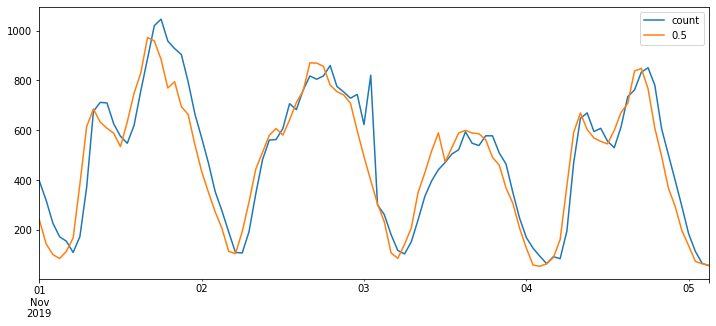

In [238]:
df_result.head(100).plot(y=['count', '0.5'], figsize=(12,5))

In [229]:
# 精度指標としてr2乗値を計算する
from sklearn.metrics import r2_score

r2_list = []

df_temp = df_result.copy()
df_temp['error'] = df_temp['count'] - df_temp['0.5']
r2 = r2_score(df_temp['count'], df_temp['0.5'])

print('Number of data:', df_temp['count'].shape[0])
print('Count max:', df_temp['count'].max())
print('Count min:', df_temp['count'].min())
print('r2:', r2)


Number of data: 1468
Count max: 1148
Count min: 35
r2: 0.8538059825017933


## 4. SageMaker Model Monitorを設定する

SageMaker Model Monitorの設定には、  
1. Endpointへ投入された推論データのリアルタイムキャプチャー設定
1. トレーニングデータからのベースラインの作成
1. モニターのスケジュール

の3つのステップがあります。順に見てきましょう  

### 4.1. 推論データキャプチャーの設定

前のステップで作成済みの推論Endpointがあるので、このEndpointを更新します。

In [227]:
# Please fill in the following for enabling data capture
endpoint_name = 'deepar-nyctaxi-2020-10-04-09-15-18-040'
s3_capture_upload_path = 's3://tuki-bkt-misc/model_monitor/endpoint-data-capture/' #example: s3://bucket-name/path/to/endpoint-data-capture/


In [228]:
from sagemaker.model_monitor import DataCaptureConfig
from sagemaker import RealTimePredictor
from sagemaker import session
import boto3
sm_session = session.Session(boto3.Session())

# Change parameters as you would like - adjust sampling percentage, 
#  chose to capture request or response or both.
#  Learn more from our documentation
data_capture_config = DataCaptureConfig(
                        enable_capture = True,
                        sampling_percentage=50,
                        destination_s3_uri=s3_capture_upload_path,
                        kms_key_id=None,
                        capture_options=["REQUEST", "RESPONSE"],
                        csv_content_types=["text/csv"],
                        json_content_types=["application/json"])

# Now it is time to apply the new configuration and wait for it to be applied
predictor = RealTimePredictor(endpoint=endpoint_name)
predictor.update_data_capture_config(data_capture_config=data_capture_config)
sm_session.wait_for_endpoint(endpoint=endpoint_name)

----------------!!

{'EndpointName': 'deepar-nyctaxi-2020-10-04-09-15-18-040',
 'EndpointArn': 'arn:aws:sagemaker:ap-northeast-1:896540033301:endpoint/deepar-nyctaxi-2020-10-04-09-15-18-040',
 'EndpointConfigName': 'deepar-nyctaxi-2020-10-04-09-15-18-040-2020-10-05-00-01-47-547',
 'ProductionVariants': [{'VariantName': 'AllTraffic',
   'DeployedImages': [{'SpecifiedImage': '633353088612.dkr.ecr.ap-northeast-1.amazonaws.com/forecasting-deepar:latest',
     'ResolvedImage': '633353088612.dkr.ecr.ap-northeast-1.amazonaws.com/forecasting-deepar@sha256:ca8d7816ea2a13baadbea73a3389ed016898e0d9c509340d9abcecb6ce750c2b',
     'ResolutionTime': datetime.datetime(2020, 10, 5, 0, 2, 21, 623000, tzinfo=tzlocal())}],
   'CurrentWeight': 1.0,
   'DesiredWeight': 1.0,
   'CurrentInstanceCount': 1,
   'DesiredInstanceCount': 1}],
 'DataCaptureConfig': {'EnableCapture': True,
  'CaptureStatus': 'Started',
  'CurrentSamplingPercentage': 50,
  'DestinationS3Uri': 's3://tuki-bkt-misc/model_monitor/endpoint-data-capture/'},
 

### 4.2. ベースラインデータの作成

ベースラインを作成するための入力データとして、モデル構築に利用した2019年の乗車データを利用します。

In [234]:
baseline_data_path = f's3://{bucket}/model_monitor/deepar_baseline_input/features-2019.json'
local_data_path = 'features-2019.json'
write_dicts_to_file(local_data_path, training_data)
copy_to_s3(local_data_path, baseline_data_path, override=True)

baseline_results_uri = f's3://{bucket}/model_monitor/deepar_baseline/'

print('Baseline data uri: {}'.format(baseline_data_path))
print('Baseline results uri: {}'.format(baseline_results_uri))

Uploading file to s3://tuki-bkt-misc/model_monitor/deepar_baseline_input/features-2019.json
Baseline data uri: s3://tuki-bkt-misc/model_monitor/deepar_baseline_input/features-2019.json
Baseline results uri: s3://tuki-bkt-misc/model_monitor/deepar_baseline/


In [237]:
from sagemaker.model_monitor import DefaultModelMonitor
from sagemaker.model_monitor.dataset_format import DatasetFormat
from sagemaker import get_execution_role

role = get_execution_role()

my_default_monitor = DefaultModelMonitor(
    role=role,
    instance_count=1,
    instance_type='ml.m5.xlarge',
    volume_size_in_gb=20,
    max_runtime_in_seconds=3600,
)

my_default_monitor.suggest_baseline(
    baseline_dataset=baseline_data_path,
    dataset_format=DatasetFormat.json(lines=False),
    output_s3_uri=baseline_results_uri,
    wait=True
)


Job Name:  baseline-suggestion-job-2020-10-05-00-21-15-697
Inputs:  [{'InputName': 'baseline_dataset_input', 'S3Input': {'S3Uri': 's3://tuki-bkt-misc/model_monitor/deepar_baseline_input/features-2019.json', 'LocalPath': '/opt/ml/processing/input/baseline_dataset_input', 'S3DataType': 'S3Prefix', 'S3InputMode': 'File', 'S3DataDistributionType': 'FullyReplicated', 'S3CompressionType': 'None'}}]
Outputs:  [{'OutputName': 'monitoring_output', 'S3Output': {'S3Uri': 's3://tuki-bkt-misc/model_monitor/deepar_baseline/', 'LocalPath': '/opt/ml/processing/output', 'S3UploadMode': 'EndOfJob'}}]
...........................2020-10-05 00:25:32,022 - __main__ - INFO - All params:{'ProcessingJobArn': 'arn:aws:sagemaker:ap-northeast-1:896540033301:processing-job/baseline-suggestion-job-2020-10-05-00-21-15-697', 'ProcessingJobName': 'baseline-suggestion-job-2020-10-05-00-21-15-697', 'Environment': {'dataset_format': '{"json": {"lines": false}}', 'dataset_source': '/opt/ml/processing/input/baseline_datas

### 生成されたconstraintとstatisticsを確認する

In [297]:
import pandas as pd

baseline_job = my_default_monitor.latest_baselining_job
schema_df = pd.json_normalize(baseline_job.baseline_statistics().body_dict["features"])
schema_df.head(10)

Parameter 'session' will be renamed to 'sagemaker_session' in SageMaker Python SDK v2.


,name,inferred_type,numerical_statistics.common.num_present,numerical_statistics.common.num_missing,numerical_statistics.mean,numerical_statistics.sum,numerical_statistics.std_dev,numerical_statistics.min,numerical_statistics.max,numerical_statistics.distribution.kll.buckets,numerical_statistics.distribution.kll.sketch.parameters.c,numerical_statistics.distribution.kll.sketch.parameters.k,numerical_statistics.distribution.kll.sketch.data
0,y,Integral,8760,0,633.360046,5.548234e+06,368.997985,5.000000,1841.00000,"[{'lower_bound': 5.0, 'upper_bound': 188.6, 'c...",0.64,2048.0,"[[564.0, 580.0, 610.0, 724.0, 710.0, 817.0, 81..."
1,time_hh,Integral,8760,0,11.500000,1.007400e+05,6.922187,0.000000,23.00000,"[{'lower_bound': 0.0, 'upper_bound': 2.3, 'cou...",0.64,2048.0,"[[10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17..."
2,count_m1h,Fractional,8760,0,633.403995,5.548619e+06,369.018246,5.000000,1841.00000,"[{'lower_bound': 5.0, 'upper_bound': 188.6, 'c...",0.64,2048.0,"[[510.0, 564.0, 580.0, 610.0, 724.0, 710.0, 81..."
3,count_m2h,Fractional,8760,0,633.468265,5.549182e+06,369.085826,5.000000,1841.00000,"[{'lower_bound': 5.0, 'upper_bound': 188.6, 'c...",0.64,2048.0,"[[347.0, 510.0, 564.0, 580.0, 610.0, 724.0, 71..."
4,count_m3h,Fractional,8760,0,633.547374,5.549875e+06,369.217405,5.000000,1841.00000,"[{'lower_bound': 5.0, 'upper_bound': 188.6, 'c...",0.64,2048.0,"[[200.0, 347.0, 510.0, 564.0, 580.0, 610.0, 72..."
5,count_m4h,Fractional,8760,0,633.619292,5.550505e+06,369.346217,5.000000,1841.00000,"[{'lower_bound': 5.0, 'upper_bound': 188.6, 'c...",0.64,2048.0,"[[124.0, 200.0, 347.0, 510.0, 564.0, 580.0, 61..."
6,count_m24h,Fractional,8760,0,634.476142,5.558011e+06,369.862759,5.000000,1841.00000,"[{'lower_bound': 5.0, 'upper_bound': 188.6, 'c...",0.64,2048.0,"[[669.0, 587.0, 565.0, 582.0, 656.0, 826.0, 94..."
7,count_m1w,Fractional,8760,0,640.216096,5.608293e+06,370.514116,5.000000,1841.00000,"[{'lower_bound': 5.0, 'upper_bound': 188.6, 'c...",0.64,2048.0,"[[561.0, 563.0, 607.0, 707.0, 683.0, 761.0, 81..."
8,weekday,Integral,8760,0,2.997260,2.625600e+04,1.997942,0.000000,6.00000,"[{'lower_bound': 0.0, 'upper_bound': 0.6, 'cou...",0.64,2048.0,"[[6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0,..."
9,mean_by_hh,Fractional,8760,0,692.773220,6.068693e+06,317.796370,141.789474,1172.70614,"[{'lower_bound': 141.78947368421052, 'upper_bo...",0.64,2048.0,"[[832.8092105263158, 822.2379385964912, 826.21..."


In [312]:
kll_buckets = schema_df[schema_df.name == 'count_m1h']['numerical_statistics.distribution.kll.buckets'].tolist()[0]
for bucket in kll_buckets:
    print(bucket)

{'lower_bound': 5.0, 'upper_bound': 188.6, 'count': 1538.0}
{'lower_bound': 188.6, 'upper_bound': 372.2, 'count': 937.0}
{'lower_bound': 372.2, 'upper_bound': 555.8, 'count': 1019.0}
{'lower_bound': 555.8, 'upper_bound': 739.4, 'count': 1789.0}
{'lower_bound': 739.4, 'upper_bound': 923.0, 'count': 1560.0}
{'lower_bound': 923.0, 'upper_bound': 1106.6, 'count': 943.0}
{'lower_bound': 1106.6, 'upper_bound': 1290.2, 'count': 602.0}
{'lower_bound': 1290.2, 'upper_bound': 1473.8, 'count': 286.0}
{'lower_bound': 1473.8, 'upper_bound': 1657.4, 'count': 74.0}
{'lower_bound': 1657.4, 'upper_bound': 1841.0, 'count': 12.0}


In [298]:
constraints_df = pd.json_normalize(baseline_job.suggested_constraints().body_dict["features"])
constraints_df.head(10)

Parameter 'session' will be renamed to 'sagemaker_session' in SageMaker Python SDK v2.


,name,inferred_type,completeness,num_constraints.is_non_negative
0,y,Integral,1.0,True
1,time_hh,Integral,1.0,True
2,count_m1h,Fractional,1.0,True
3,count_m2h,Fractional,1.0,True
4,count_m3h,Fractional,1.0,True
5,count_m4h,Fractional,1.0,True
6,count_m24h,Fractional,1.0,True
7,count_m1w,Fractional,1.0,True
8,weekday,Integral,1.0,True
9,mean_by_hh,Fractional,1.0,True


### 4.3. モニタースケジュールの有効化
ここまでのステップで、推論Endpointに対してデータキャプチャーを設定し、トレーニングデータからベースラインを作成しました。この2つの設定を元に、モニタリングのスケジュールを設定することで、データドリフトの監視ができるようになります。  

スケジュールは、ここではModel Monitorが提供する`CronExpressionGenerator`というライブラリーを利用して、hourlyの設定を行っています。cron形式で与えることも可能です。実際には評価したいインターバルで設定してください。

In [299]:
from sagemaker.model_monitor import CronExpressionGenerator
from time import gmtime, strftime

mon_schedule_name = 'DEMO-XGBoost-monitor'
s3_report_path = 's3://tuki-bkt-misc/model_monitor/monitoring_report/'
my_default_monitor.create_monitoring_schedule(
    monitor_schedule_name=mon_schedule_name,
    endpoint_input=predictor.endpoint,
    output_s3_uri=s3_report_path,
    statistics=my_default_monitor.baseline_statistics(),
    constraints=my_default_monitor.suggested_constraints(),
    schedule_cron_expression=CronExpressionGenerator.hourly(),
    enable_cloudwatch_metrics=True,

)

Parameter 'session' will be renamed to 'sagemaker_session' in SageMaker Python SDK v2.
Parameter 'session' will be renamed to 'sagemaker_session' in SageMaker Python SDK v2.



Creating Monitoring Schedule with name: DEMO-XGBoost-monitor


In [300]:
desc_schedule_result = my_default_monitor.describe_schedule()
print('Schedule status: {}'.format(desc_schedule_result['MonitoringScheduleStatus']))

Schedule status: Pending


In [273]:
client.list_monitoring_schedules(EndpointName=endpoint_name)

{'MonitoringScheduleSummaries': [],
 'ResponseMetadata': {'RequestId': '2d742ae9-7d97-4cd1-a45e-c7e9542be0c6',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': '2d742ae9-7d97-4cd1-a45e-c7e9542be0c6',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '34',
   'date': 'Sun, 13 Sep 2020 20:34:44 GMT'},
  'RetryAttempts': 0}}

作成されたスケジュールのdescribe結果を見ると、利用するベースラインのS3Uriやスケジュール間隔などがわかります。

In [304]:
my_default_monitor.describe_schedule()

{'MonitoringScheduleArn': 'arn:aws:sagemaker:ap-northeast-1:896540033301:monitoring-schedule/demo-xgboost-monitor',
 'MonitoringScheduleName': 'DEMO-XGBoost-monitor',
 'MonitoringScheduleStatus': 'Scheduled',
 'CreationTime': datetime.datetime(2020, 9, 13, 21, 7, 30, 139000, tzinfo=tzlocal()),
 'LastModifiedTime': datetime.datetime(2020, 9, 13, 21, 17, 4, 755000, tzinfo=tzlocal()),
 'MonitoringScheduleConfig': {'ScheduleConfig': {'ScheduleExpression': 'cron(0 * ? * * *)'},
  'MonitoringJobDefinition': {'BaselineConfig': {'ConstraintsResource': {'S3Uri': 's3://tuki-bkt-misc/model_monitor/baseline/constraints.json'},
    'StatisticsResource': {'S3Uri': 's3://tuki-bkt-misc/model_monitor/baseline/statistics.json'}},
   'MonitoringInputs': [{'EndpointInput': {'EndpointName': 'DEMO-XGBoostEndpoint-2020-09-13-18-37-31',
      'LocalPath': '/opt/ml/processing/input/endpoint',
      'S3InputMode': 'File',
      'S3DataDistributionType': 'FullyReplicated'}}],
   'MonitoringOutputConfig': {'Monit

## 5. モデルを運用する
ここまでのステップが完了すると、推論Endpointを運用していけばデータがキャプチャーされ、ベースラインと比較したデータドリフトの評価が行われます。今回のblogでは、1月、2月、3月と順に推論データを投入して、データドリフトが顕在化するかどうかを見ていきましょう。  

まず、2020年1月から2月のデータを元に推論を実行します。ここでは2ヶ月分のデータを一括して推論していますが、実際のモデル運用では時間経過に伴って順次推論のリクエストが投入されていると考えてください。  

In [305]:
df_202001 = df_features[(df_features.index >= '2020-01-01') & (df_features.index < '2020-03-01')].copy()
df_202001['pred'] = exec_prediction(df_202001)

推論の実行が終わったら、データキャプチャーの出力先として設定したS3のパスをチェックしてください。推論Endpointの名前をprefixとしてデータが出力されているはずです。  
![Model Monitorの出力先として設定したS3パス](image/screenshot1_s3.png)

Model Monitorによるスケジュール実行が完了すると、出力先として指定したS3パスにレポートが出力されます。

1月、2月分の推論データに対するModel Monitorのレポートはこのようになりました。

次に、3，4月のデータによる推論を実行してみましょう。

In [305]:
df_202003 = df_features[(df_features.index >= '2020-03-01') & (df_features.index < '2020-05-01')].copy()
df_202003['pred'] = exec_prediction(df_202003)

1月、2月分の推論データに対するModel Monitorのレポートはこのようになりました。

最後に、5,6月のデータによる推論を実行します。

In [305]:
df_202005 = df_features[(df_features.index >= '2020-05-01') & (df_features.index < '2020-07-01')].copy()
df_202005['pred'] = exec_prediction(df_202005)